In [1]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import ny_public_transportation as npt
npt.set_open_data_api_key(open(".opendatatoken").read().strip())

# Load Data

We are only looking at the dip, so March 2020 to May 2020

In [159]:
START_DATE = "2020-03-01"
END_DATE = "2020-04-30"
df_subway = npt.retrieve_mta_data_as_df([2020], date_range=(START_DATE, END_DATE))
df_subway = npt.turnstile_to_counts(df_subway, granularity="4H", detail_level="station", interpolate=True)

df_citibike = npt.retrieve_citibike_data_as_df(
    start_date=pd.to_datetime(START_DATE).strftime("%Y%m"),
    end_date=(pd.to_datetime(END_DATE) + pd.Timedelta(days=31)).strftime("%Y%m")
)
df_citibike = npt.trips_to_counts(df_citibike, granularity="4H", interpolate=True)
display(df_subway.head())
display(df_citibike.head())

Fold 4500000 finished in 12.53233790397644 seconds.Fold 6000000 finished in 12.534189939498901 seconds.

Fold 3000000 finished in 13.773532152175903 seconds.
Fold 7500000 finished in 13.796770811080933 seconds.
Fold 0 finished in 19.24722194671631 seconds.
Fold 1500000 finished in 22.736253023147583 seconds.
Retrieving data from 202003,202004,202005


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:16<00:00,  5.38s/it]


2020-03-01 00:00:00 2020-06-05 12:00:00


,station,datetime_rounded,entries_diff,exits_diff
0,1 AV,2020-03-01 04:00:00,0.0,0.0
1,1 AV,2020-03-01 08:00:00,153.0,284.0
2,1 AV,2020-03-01 12:00:00,447.0,714.0
3,1 AV,2020-03-01 16:00:00,1260.0,1556.0
4,1 AV,2020-03-01 20:00:00,1495.0,2010.0


,citibike_station,datetime_rounded,start_count,end_count
0,1 Ave & E 110 St,2020-03-01 00:00:00,0.0,3.0
1,1 Ave & E 110 St,2020-03-01 04:00:00,1.0,1.0
2,1 Ave & E 110 St,2020-03-01 08:00:00,1.0,1.0
3,1 Ave & E 110 St,2020-03-01 12:00:00,4.0,4.0
4,1 Ave & E 110 St,2020-03-01 16:00:00,0.0,1.0


In [160]:
MAX_DATETIME = df_subway['datetime_rounded'].max()
MIN_DATETIME = df_subway['datetime_rounded'].sort_values().unique()[1] # after diff, the first value is NaT
trim_df_datetime = (
    lambda df: df.loc[
        (df['datetime_rounded'] >= MIN_DATETIME) & (df['datetime_rounded'] <= MAX_DATETIME), :
    ]
)
df_citibike = trim_df_datetime(df_citibike)
df_subway = trim_df_datetime(df_subway)

## Hospital-level

In [161]:
# load hospital data
hospital_df = pd.read_pickle('hospitals.pkl')
hospital_df

,Name,coord,lat,lng
0,Bellevue Hospital Center,"(40.7396865, -73.9762044)",40.739686,-73.976204
1,BronxCare Hospital Center,"(40.8434469, -73.9110165)",40.843447,-73.911017
2,BronxCare Hospital Center,"(40.8434469, -73.9110165)",40.843447,-73.911017
3,Brookdale Hospital Medical Center,"(40.7127753, -74.0059728)",40.712775,-74.005973
4,Brooklyn Hospital Center - Downtown Campus,"(40.6781784, -73.9441579)",40.678178,-73.944158
...,...,...,...,...
57,Staten Island University Hosp-North,"(40.5795317, -74.1502007)",40.579532,-74.150201
58,Staten Island University Hospital Prince's Bay,"(40.5168211, -74.1963916)",40.516821,-74.196392
59,University Hospital of Brooklyn,"(40.6781784, -73.9441579)",40.678178,-73.944158
60,Woodhull Medical & Mental Health Center,"(40.6995553, -73.9424944)",40.699555,-73.942494


In [168]:
px.set_mapbox_access_token(open('.mapbox_token').read())
def get_nearby_stations_for_hospital(hospital, radius, shrink_factor):
    nearby_subways = npt.find_nearby_stations((hospital["lat"], hospital["lng"]), radius=radius, kind="subway")
    nearby_citibikes = npt.find_nearby_stations((hospital["lat"], hospital["lng"]), radius=radius / shrink_factor, kind="citibike")
    
    return nearby_subways, nearby_citibikes

def build_dataframes(hospital_df, radius, shrink_factor):
    # build lists of dataframes
    list_nearby_subways, list_nearby_citibikes = zip(
        *[get_nearby_stations_for_hospital(row, radius, shrink_factor) for _, row in hospital_df.iterrows()]
    )
    
    df_nearby_subways = pd.concat(list_nearby_subways).drop_duplicates()
    df_nearby_citibikes = pd.concat(list_nearby_citibikes).drop_duplicates()
    
    return df_nearby_subways, df_nearby_citibikes

def get_filtered_df(df_subway, df_citibike, df_nearby_subways, df_nearby_citibikes):
    # filter df_subway and df_citibike based on occurences in df_nearby_subways and df_nearby_citibikes
    df_subway_graph = df_subway.loc[df_subway['station'].isin(df_nearby_subways['station'].unique())]
    df_citibike_graph = df_citibike.loc[df_citibike['citibike_station'].isin(df_nearby_citibikes['station'].unique())]
    max_datetime = df_subway_graph['datetime_rounded'].max()
    min_datetime = df_subway_graph['datetime_rounded'].min()
    df_citibike_graph = df_citibike_graph.loc[(df_citibike_graph['datetime_rounded'] >= min_datetime) & (df_citibike_graph['datetime_rounded'] <= max_datetime)]

    # merge df_subway_graph and df_citibike_graph
    return (
        df_subway_graph.groupby('datetime_rounded').sum().reset_index()
        .merge(
            df_citibike_graph.groupby('datetime_rounded').sum().reset_index(),
            on='datetime_rounded',
            validate='1:1'
        )
    )



def visualize_hospital_map(df_nearby):
    figure = px.scatter_mapbox(
            df_nearby,
            lat="lat",
            lon="lng",
            color="transpotation",
            hover_name="station",
            hover_data=["distance"],
            zoom=12,
            mapbox_style="carto-positron",
        )
    figure.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
        ),
    )
    return figure


def graph_all_hospitals(radius=1000, window="14D", map=False, shrink_factor=2):
    df_nearby_subways, df_nearby_citibikes = build_dataframes(hospital_df, radius, shrink_factor)
    df_target_hospitals = pd.DataFrame(
        {
            "station": hospital_df["Name"],
            "lat": hospital_df["lat"],
            "lng": hospital_df["lng"],
            "distance": 0,
        }
    )
    df_nearby_subways['transpotation'] = 'subway'
    df_nearby_citibikes['transpotation'] = 'citibike'
    df_target_hospitals['transpotation'] = 'hospital'

    df_nearby = pd.concat([df_nearby_subways, df_nearby_citibikes, df_target_hospitals])
    df_nearby = df_nearby.reset_index(drop=True)

    if map:
        figure = visualize_hospital_map(df_nearby)
        figure.update_layout(
            title=f"Nearby Stations within {radius} meters of NYC Hospitals",
        )
        figure.show()

    df_graph = get_filtered_df(df_subway, df_citibike, df_nearby_subways, df_nearby_citibikes)
    print(df_graph.sort_values('datetime_rounded'))
    # plot raw counts
    figure = px.line(
        (
            df_graph
            #.resample('1D', on='datetime_rounded').sum().reset_index()
            .assign(
                entries_diff = lambda df: np.log(df['entries_diff'] + 1),
                exits_diff = lambda df: np.log(df['exits_diff'] + 1),
                start_count = lambda df: np.log(df['start_count'] + 1),
                end_count = lambda df: np.log(df['end_count'] + 1)
            )
        ),
        x='datetime_rounded',
        y=['entries_diff', 'exits_diff', 'start_count', 'end_count'],
        labels={
            'datetime_rounded': 'Date',
            'value': 'Count',
            'variable': 'Type'
        },
        title=f"Entries and Exits of Subway and Citi Bike Stations near all Hospitals",
        color_discrete_sequence=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e'],
        #symbol_sequence=['circle', 'square', 'circle', 'square'],

    )
    figure.show()
    # plot rolling pct change
    figure = npt.plot_rolling_pct_change(
        df_graph,
        window=window,
        datetime_col='datetime_rounded'
    )
    figure.update_layout(
        title=f"Rolling Percentage Change of All hospitals' Nearby Stations, {window}",
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        )
    )
    figure.show()

graph_all_hospitals(map=True, shrink_factor=2, window="4H", radius=1000)


       datetime_rounded   entries_diff     exits_diff  start_count  end_count
0   2020-03-01 04:00:00   26812.000000   25175.000000        143.0      157.0
1   2020-03-01 08:00:00   46571.333333   42602.333333       1394.0     1270.0
2   2020-03-01 12:00:00  200061.000000  192701.333333       2640.0     2516.0
3   2020-03-01 16:00:00  353998.666667  318059.666667       2088.0     2309.0
4   2020-03-01 20:00:00  370709.916667  308937.500000        689.0      719.0
..                  ...            ...            ...          ...        ...
361 2020-04-30 08:00:00   46879.666667   57364.333333        378.0      415.0
362 2020-04-30 12:00:00   40297.666667   56421.166667       1003.0      915.0
363 2020-04-30 16:00:00   65194.333333   58586.000000       1541.0     1468.0
364 2020-04-30 20:00:00   58727.666667   53127.000000        297.0      363.0
365 2020-05-01 00:00:00   57393.000000   52408.000000         47.0       54.0

[366 rows x 5 columns]


## VAR

<AxesSubplot:xlabel='datetime_rounded'>

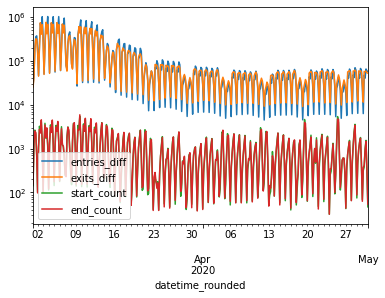

In [171]:
df_model = get_filtered_df(df_subway, df_citibike,
                           *build_dataframes(hospital_df, radius=1000, shrink_factor=2))
df_model.set_index('datetime_rounded').plot(logy=True)

In [164]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

In [165]:
def cointegration_test(test, alpha=0.05, verbose=True):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(test, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6):
        return str(val).ljust(length)

    # Summary
    if verbose:
        print('\n  Name   :: Test Stat > C(95%)       => Signif ')
    for col, trace, cvt in zip(test.columns, traces, cvts):
        result = trace > cvt
        if verbose:
            print(adjust(col), '::', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), '  =>  ', result)
        if not result:
            if verbose:
                print(f'{col} does not pass cointegration test')
            return False
    return True

def check_stationarity(df, alpha=0.05, verbose=True):
    """Perform ADFuller to check if the series is stationary"""
    cols = df.columns
    result = True
    for col in cols:
        result = result and adfuller(df[col])[1] < alpha
        if verbose:
            print(f'{col} is stationary: {adfuller(df[col])[1] < alpha}')
    return result
    
def granger_causation_matrix(data, variables, test = 'ssr_ftest', verbose=False, maxlag=12):
    causality_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in causality_matrix.columns:
        for r in causality_matrix.index:
            if c == r:
                causality_matrix.loc[r, c] = 1
                continue
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            causality_matrix.loc[r, c] = min_p_value

    causality_matrix.columns = [var + '_x' for var in variables]
    causality_matrix.index = [var + '_y' for var in variables]
    return causality_matrix

## Differencing

In [170]:
GRANULARITY = "4H"
def calculate_lags(granularity, verbose=False):
    """
    Calculate the lags for daily and weekly seasonality.
    """
    granularity_value = int(granularity[:-1])
    # handle daily and weekly seasonality
    if granularity[-1] == 'D':
        granularity_value *= 24
    elif granularity[-1] == 'W':
        granularity_value *= 24 * 7

    daily_lag = int(24 / granularity_value)
    weekly_lag = daily_lag * 7

    # handle 0's
    check_if_zero = lambda x: 1 if x == 0 else x
    daily_lag = check_if_zero(daily_lag)
    weekly_lag = check_if_zero(weekly_lag)
    if verbose:
        print(f"For {granularity} granularity, daily lag: {daily_lag}, weekly lag: {weekly_lag}")
    return daily_lag, weekly_lag

# Test the function
granularity = "4H"
daily_lag, weekly_lag = calculate_lags(granularity)
print(f"For {granularity} granularity, daily lag: {daily_lag}, weekly lag: {weekly_lag}")


For 4H granularity, daily lag: 6, weekly lag: 42


In [167]:
results.fittedvalues

,subway_entries,subway_exits,citibike_rentals,citibike_returns
datetime_rounded,,,,
2020-03-12 04:00:00,16658.094513,15690.611882,-83.329073,-76.458033
2020-03-12 08:00:00,-9042.360149,-8953.194273,-186.399370,-294.326370
2020-03-12 12:00:00,-40449.829504,-39724.468589,-40.474339,-146.775843
2020-03-12 16:00:00,-55338.594522,-37943.075858,518.922021,382.904246
2020-03-12 20:00:00,-91320.143425,-59395.064564,-973.609291,-882.457983
...,...,...,...,...
2020-05-31 08:00:00,5117.411306,4719.197295,-679.602600,-503.425507
2020-05-31 12:00:00,246.269810,2223.586604,-3686.739207,-3324.532011
2020-05-31 16:00:00,-7303.017614,-10156.314374,-2780.205771,-3344.116737


For 4H granularity, daily lag: 6, weekly lag: 42

  Name   :: Test Stat > C(95%)       => Signif 
subway_entries :: 295.21    > 40.1749    =>   True
subway_exits :: 161.87    > 24.2761    =>   True
citibike_rentals :: 67.24     > 12.3212    =>   True
citibike_returns :: 23.26     > 4.1296     =>   True
subway_entries is stationary: True
subway_exits is stationary: True
citibike_rentals is stationary: True
citibike_returns is stationary: True
using 18 lags


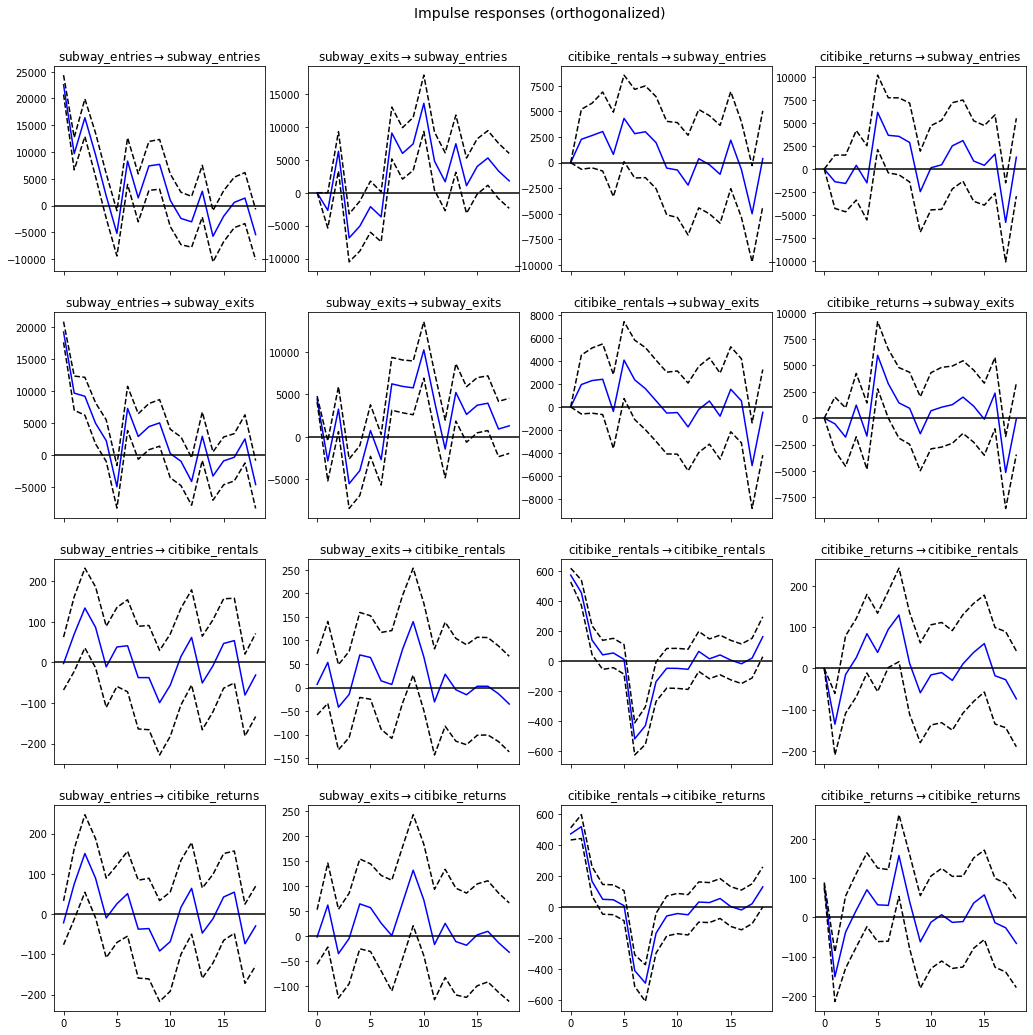

In [172]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
def difference_df(df, granularity, verbose=False):
    """
    Difference the dataframe based on the granularity.
    """
    daily_lag, weekly_lag = calculate_lags(granularity, verbose=verbose)
    df_diff = df.diff(periods=daily_lag)
    df_diff = df_diff.diff(periods=weekly_lag)
    df_diff = df_diff.dropna()
    return df_diff

def plot_fitted_vs_actual(model, df, granularity):
    colors = px.colors.qualitative.Plotly
    append_alpha = lambda color: f"rgba({' ,'.join([str(int(c * 255)) for c in to_rgb(color)])}, 0.5)"
    df_diff = difference_df(df, granularity)
    names = df_diff.columns
    df = pd.merge(
        df_diff,
        model.fittedvalues,
        left_index=True,
        right_index=True,
        suffixes=('_actual', '_fitted')
    )
    fig = go.Figure()
    for color, name in zip(colors[:len(names)], names):
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[name + '_actual'],
            mode='lines',
            name=name + '_actual',
            line=dict(color=append_alpha(color)),
            legendgroup=name
        ))
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[name + '_fitted'],
            mode='lines',
            name=name + '_fitted',
            line=dict(color=color, dash='dot'), # 'dash', 'dot', and 'dashdot'
            legendgroup=name
        ))
    fig.show()


def fit_var_model(df, granularity, maxlags=12, verbose=True):
    """
    Fit a VAR model to the dataframe.
    """
    assert len(df.columns) == 4
    df_diff = difference_df(df, granularity, verbose=verbose)
    # data checks
    assert cointegration_test(df_diff, verbose=verbose)
    assert check_stationarity(df_diff, verbose=verbose)
    model = VAR(df_diff, freq=granularity)
    results = model.fit(maxlags=maxlags, ic='aic')
    if verbose:
        print(f"using {results.k_ar} lags")
    return results

results = fit_var_model(df_model.set_index('datetime_rounded').rename(
    columns={
        'entries_diff': 'subway_entries',
        'exits_diff': 'subway_exits',
        'start_count': 'citibike_rentals',
        'end_count': 'citibike_returns'
    }
    ), GRANULARITY, maxlags=20)
irf_results = results.irf(results.k_ar)
irf_results.plot(orth=True, figsize=(15, 15))
plot_fitted_vs_actual(results, df_model.set_index('datetime_rounded').rename(
    columns={
        'entries_diff': 'subway_entries',
        'exits_diff': 'subway_exits',
        'start_count': 'citibike_rentals',
        'end_count': 'citibike_returns'
    }
    ), GRANULARITY)
print()

(<Figure size 1080x1080 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'subway_entries$\\rightarrow$subway_entries'}>,
         <AxesSubplot:title={'center':'subway_exits$\\rightarrow$subway_entries'}>,
         <AxesSubplot:title={'center':'citibike_rentals$\\rightarrow$subway_entries'}>,
         <AxesSubplot:title={'center':'citibike_returns$\\rightarrow$subway_entries'}>],
        [<AxesSubplot:title={'center':'subway_entries$\\rightarrow$subway_exits'}>,
         <AxesSubplot:title={'center':'subway_exits$\\rightarrow$subway_exits'}>,
         <AxesSubplot:title={'center':'citibike_rentals$\\rightarrow$subway_exits'}>,
         <AxesSubplot:title={'center':'citibike_returns$\\rightarrow$subway_exits'}>],
        [<AxesSubplot:title={'center':'subway_entries$\\rightarrow$citibike_rentals'}>,
         <AxesSubplot:title={'center':'subway_exits$\\rightarrow$citibike_rentals'}>,
         <AxesSubplot:title={'center':'citibike_rentals$\\rightarrow$citibike_rentals'}>,
         <A

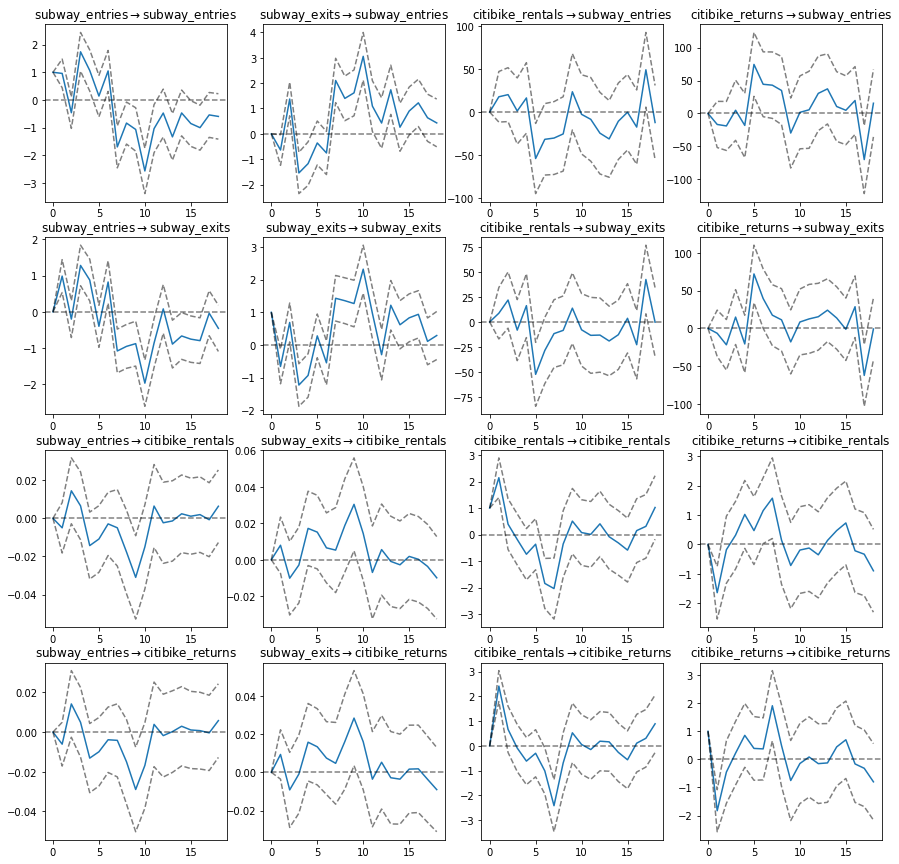

In [173]:
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar.util as util
def plot_irf(irf_results, orth=True, signif=0.05):
    """
    Plot the impulse response functions.
    """
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    var_names = irf_results.model.names
    for i, var in enumerate(var_names):
        for j, imp in enumerate(var_names):
            y = irf_results.irfs[:, i, j] if not orth else irf_results.orth_irfs[:, i, j]
            ax[i, j].plot(y)
            ax[i, j].set_title(fr"{imp}$\rightarrow${var}")
            ax[i, j].axhline(0, color='k', linestyle='--', alpha=0.5)
            # confidence intervals
            q = util.norm_signif_level(signif)
            k = len(irf_results.model.names)
            stderr = irf_results.cov(orth=orth)
            errors = np.sqrt(stderr[:, j * k + i, j * k + i])
            #y - q * error
            ax[i, j].plot(y - q * errors, color='k', linestyle='--', alpha=0.5)
            #y + q * error
            ax[i, j].plot(y + q * errors, color='k', linestyle='--', alpha=0.5)

    return fig, ax

plot_irf(irf_results, orth=False, signif=0.05)

In [179]:
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np

def add_irf_to_plot(irf_results, model_name, fig=None, orth=True, signif=0.05, color=None, opacity=1, plot_ci=True, **kwargs):
    """
    Args:
    - fig: The plotly figure object to which the IRF data should be added.
    - irf_results: The results object containing the IRF data.
    - model_name: The name or identifier for the model (used for legend group).
    - orth: Whether or not to use orthogonalized IRFs.
    - signif: Significance level for confidence intervals.
    - color: Color to be used for the traces of this model. If None, plotly's default colors will be used.
    - opacity: Opacity of the traces.
    - plot_ci: Whether or not to plot the confidence intervals.
    """
    var_names = irf_results.model.names
    first_time = False
    hover_template = kwargs.get('hover_template', None)
    get_hover_template = (
        lambda imp, var: f"{imp}→{var}: %{{y:.2f}}" if hover_template is None else hover_template
    )
    if fig is None:
        fig = sp.make_subplots(rows=4, cols=4, subplot_titles=[f"{imp}→{var}" for var in var_names for imp in var_names])
        first_time = True
    if color is not None:
        color = f"rgba({','.join([str(c) for c in color])}, {opacity})"
    for i, var in enumerate(var_names):
        for j, imp in enumerate(var_names):
            y = irf_results.irfs[:, i, j] if not orth else irf_results.orth_irfs[:, i, j]
            y = y.copy() # prevent in-place modification
            # confidence intervals
            q = util.norm_signif_level(signif)
            k = len(irf_results.model.names)
            stderr = irf_results.cov(orth=orth)
            errors = np.sqrt(stderr[:, j * k + i, j * k + i])
            # if orth:
            #     # normalize the orthogonalized IRFs w.r.t. standard deviation of the impulse variable
            #    # print(np.std(irf_results.model.endog[:, j]), np.max(y), np.min(y))
            #     y /= np.std(irf_results.model.endog[:, j])
            #     # TODO: This is a hacky way to normalize the confidence intervals, not sure if it's correct
            #     errors /= np.std(irf_results.model.endog[:, j])
            # Plotting the main line
            fig.add_trace(go.Scatter(x=list(range(len(y))), y=y, mode='lines', legendgroup=model_name, line=dict(color=color, width=1),
                                      name=f"{model_name}",
                                      hovertemplate=get_hover_template(imp, var),
                                      showlegend=True if i == 0 and j == 0 else False
                                      ),
                          row=i+1, col=j+1)

            # Plotting the confidence interval
            if plot_ci:
                fig.add_trace(go.Scatter(x=list(range(len(y))), y=y - q * errors, mode='lines', legendgroup=model_name, line=dict(dash='dash', color=color, width=0.5), showlegend=False),
                            row=i+1, col=j+1)
                fig.add_trace(go.Scatter(x=list(range(len(y))), y=y + q * errors, mode='lines', legendgroup=model_name, line=dict(dash='dash', color=color, width=0.5), showlegend=False),
                            row=i+1, col=j+1)

            # Add a horizontal line at y=0
            if first_time:
                fig.add_shape(go.layout.Shape(type="line", x0=0, x1=len(y)-1, y0=0, y1=0, line=dict(color="black", width=0.7, dash="dot")), row=i+1, col=j+1)
                fig.update_layout(
                    title="Impulse Response Functions",
                    showlegend=True,
                    height=1000,
                    width=1000,
                    template='simple_white',
                    #margin=dict(l=50, r=50, t=100, b=50),
                )
                fig.for_each_annotation(lambda a: a.update(font=dict(size=10)))


    return fig

add_irf_to_plot(irf_results, "VAR1", orth=True, signif=0.05, plot_ci=True, color=(255, 0, 0), opacity=0.8)


In [102]:
def resample_coarser(df, window: str = "7D", datetime_col: str = "datetime_rounded",
                           cols: list = None, groupby_key: str = None):
    """
    Resample the dataframe to a coarser granularity.

    Parameters
    ----------
    df : pandas.DataFrame
        A dataframe of data.
    window : str
        Pandas time series frequency string. Default is '7D' (7 days).
    cols : list
        A list of columns to calculate rolling percent change on.
    groupby_key : str
        The column to group by. Default is None (Assuming only one group).

    Returns
    -------
    pandas.DataFrame
    """
    df = df.copy()
    if cols is None:
        cols = df.columns[~df.columns.isin([datetime_col, groupby_key])]

    if groupby_key is not None:
        # Group by the specified key
        assert isinstance(groupby_key, str), "groupby_key must be a string."
        grouped = df.groupby(groupby_key)
    else:
        # If no groupby_key is given, create a single group
        grouped = [("", df)]
        
    result_dfs = []
    for group, group_df in grouped:
        group_df = group_df.set_index(datetime_col).resample(window)
        agg_dict = {c: 'sum' for c in cols}

        # count here is needed to make sure the rolling window is full
        identifier_col = list(agg_dict.keys())[0]
        agg_dict[identifier_col] = ['sum', 'count']
        group_df = group_df.agg(agg_dict)
        group_df.columns = group_df.columns.map('_'.join) # flatten the multi-index

        count_col = identifier_col + '_count'
        desired_count = group_df[count_col].max()
        # get rid of the windows that are not full
        group_df = group_df.loc[group_df[count_col] == desired_count, :].drop(count_col, axis=1)
        group_df.columns = group_df.columns.str.replace('_sum', '') # restore the column names

        group_df = group_df.reset_index().dropna()

        # Append the groupby_key to the result if it exists
        if groupby_key is not None:
            group_df[groupby_key] = group

        result_dfs.append(group_df)

    # Concatenate the results and return
    result_df = pd.concat(result_dfs, axis=0, ignore_index=True)
    return result_df


In [ ]:
0-4, 4-8, 8-12, 12-16, 16-20, 20-24
n 4:30am

3:44 1
4:00 2
6:33 3

1 2 3 4 5 6
3, 7, 11 - sum
1.5, 2.5, 3.6,

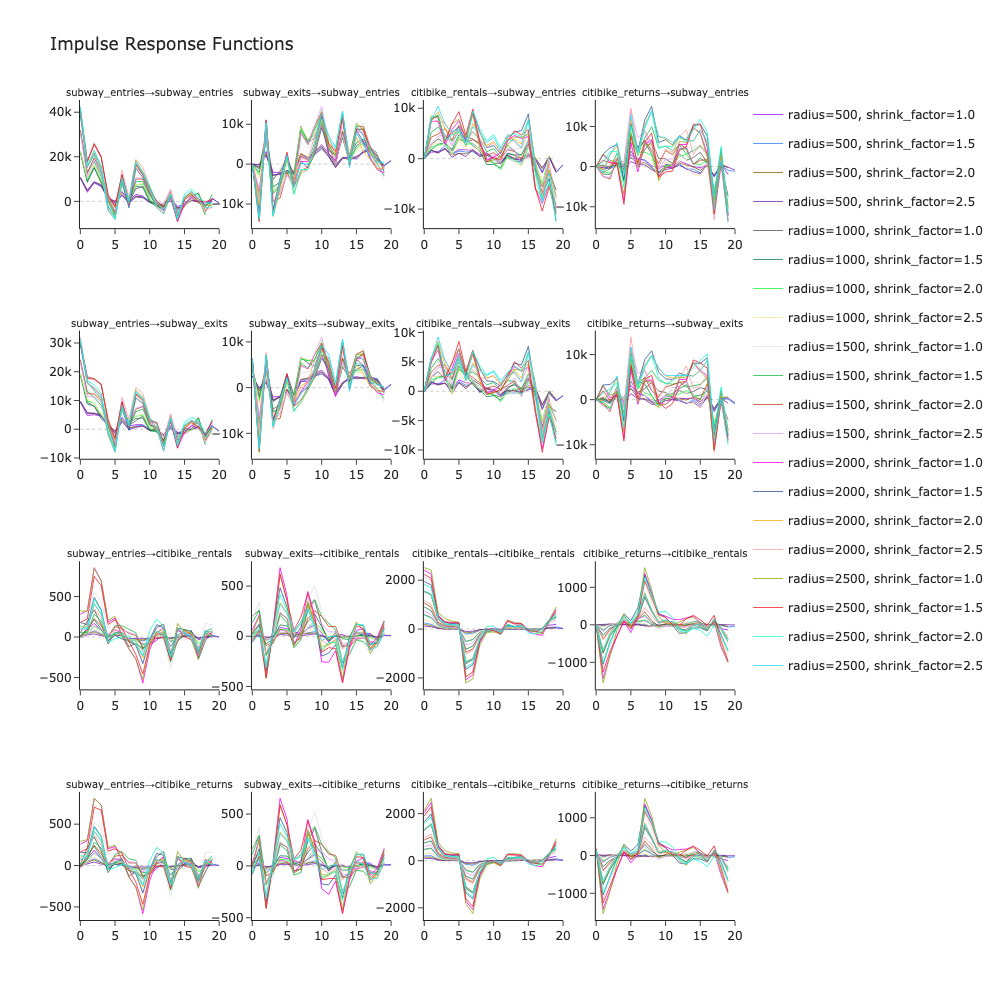

In [182]:
from matplotlib.colors import to_rgb
from IPython.display import Image
RADIUS_GRID = np.arange(500, 3000, 500) # 500, 1000, .... 3000
SHRINK_FACTOR_GRID = np.arange(1, 3, 0.5) # 1, 1.5 .... 3
WINDOW_GRID = ["4H", "1D", "7D"] # one big plot for each window
def grid_search(radius_grid, shrink_factor_grid, window, maxlags=20, verbose=False):
    fig = None
    colors = px.colors.qualitative.Alphabet
    def _color_generator(colors):
        for color in colors:
            color = to_rgb(color)
            color = [int(c * 255) for c in color]
            yield color
    color_generator = _color_generator(colors)
    for radius in radius_grid:
        for shrink_factor in shrink_factor_grid:
            df_model = get_filtered_df(df_subway, df_citibike,
                                       *build_dataframes(hospital_df, radius, shrink_factor))
            if window != '4H':
                df_model = resample_coarser(df_model, window=window, datetime_col='datetime_rounded')
            df_model = df_model.set_index('datetime_rounded').rename(
                columns={
                    'entries_diff': 'subway_entries',
                    'exits_diff': 'subway_exits',
                    'start_count': 'citibike_rentals',
                    'end_count': 'citibike_returns'
                }
            )
            results = fit_var_model(df_model, window, maxlags=maxlags, verbose=verbose)
            irf_results = results.irf(results.k_ar)
            fig = add_irf_to_plot(irf_results, f"radius={radius}, shrink_factor={shrink_factor}",
                                   fig=fig,
                                   orth=True, signif=0.05, plot_ci=False,
                                    color=next(color_generator), opacity=0.8,
                                    hover_template=f"r={radius}, s={shrink_factor}, y=%{{y:.2f}}, x=%{{x}}"
                                    )
            fig.update_layout(
                hoverlabel = dict(
                    bgcolor = "white",
                    font_size = 8,
                    font_family = "Rockwell"
                )
            )
    return fig

Image(grid_search(RADIUS_GRID, SHRINK_FACTOR_GRID, WINDOW_GRID[0]).to_image(format="png", engine="kaleido"))


For 8H granularity, daily lag: 3, weekly lag: 21

  Name   :: Test Stat > C(95%)       => Signif 
subway_entries :: 201.82    > 40.1749    =>   True
subway_exits :: 119.98    > 24.2761    =>   True
citibike_rentals :: 49.14     > 12.3212    =>   True
citibike_returns :: 10.81     > 4.1296     =>   True
subway_entries is stationary: True
subway_exits is stationary: True
citibike_rentals is stationary: True
citibike_returns is stationary: True
using 9 lags
For 8H granularity, daily lag: 3, weekly lag: 21

  Name   :: Test Stat > C(95%)       => Signif 
subway_entries :: 205.73    > 40.1749    =>   True
subway_exits :: 124.53    > 24.2761    =>   True
citibike_rentals :: 53.58     > 12.3212    =>   True
citibike_returns :: 11.16     > 4.1296     =>   True
subway_entries is stationary: True
subway_exits is stationary: True
citibike_rentals is stationary: True
citibike_returns is stationary: True
using 6 lags
For 8H granularity, daily lag: 3, weekly lag: 21

  Name   :: Test Stat > C(95%)  

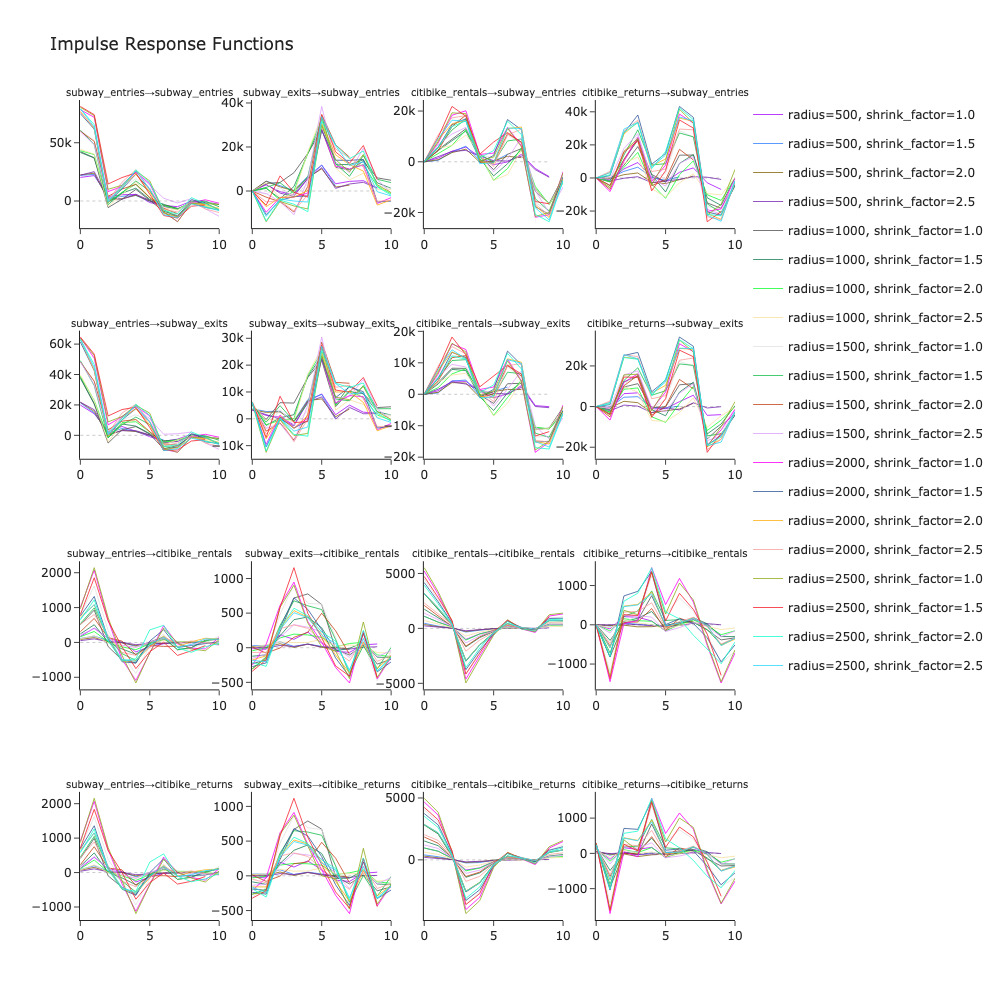

In [183]:
Image(grid_search(RADIUS_GRID, SHRINK_FACTOR_GRID, "8H", maxlags=10, verbose=True).to_image(format="png", engine="kaleido"))